# Try community detection

In [1]:
# use autoreload
%load_ext autoreload
%autoreload 2

import yaml
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import seaborn as sns

## Embed of low pT and high pt tracks

In [2]:
with open("configs/4c_testing.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/UnsupervisedLearning/JEPA/ToyTrack/2_testing/artifacts/best-92512mhb-val_loss=0.003267-epoch=99.ckpt"

# Use lightning load
model = TrueContrastiveLearning.load_from_checkpoint(checkpoint_path).to("cuda")

# Make sure the model has low pT tracks
model.hparams["dataset_args"]["particle_guns"][0]["pt"] = [2.5, 2.6]

# Set the model to also have a larger batch size
# model.hparams["batch_size"] = 2000

# Get dataloader
dataloader = model.train_dataloader()

# Get a batch
batch = next(iter(dataloader))

NameError: name 'TrueContrastiveLearning' is not defined

Max edge index: 19
Distances shape: torch.Size([380000])
Sample distances: tensor([2.4164e-02, 7.0801e-02, 7.8432e-02, 5.5617e+01, 5.5617e+01],
       device='cuda:0')


/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/lightning/pytorch/core/module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


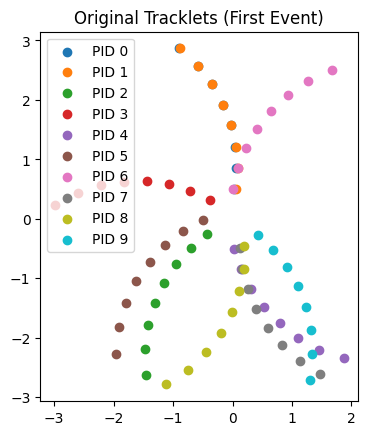

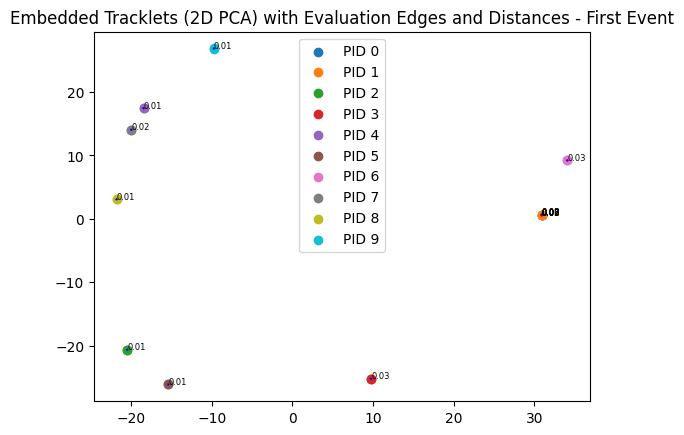

First Batch Metrics:
  Efficiency: 1.0000
  Purity: 0.9103
  Mean True Distance: 0.0216
  Mean Fake Distance: 39.4408


In [5]:
with torch.no_grad():
    batch = {k: v.to("cuda") if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
    results = model.shared_evaluation(batch, batch_idx=0)

# Get the embeddings
low_pt_embeddings = results["embeddings"].cpu().numpy()

Max edge index: 19
Distances shape: torch.Size([380000])
Sample distances: tensor([ 0.1921,  7.4821,  7.4629, 48.3710, 48.6396], device='cuda:0')


/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/lightning/pytorch/core/module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


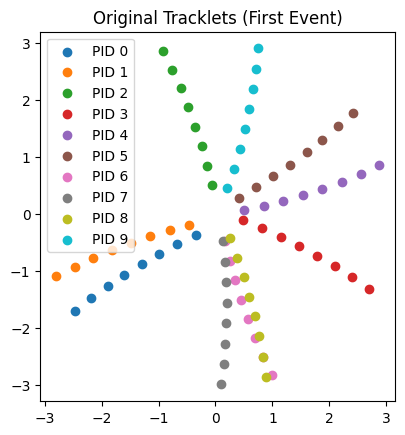

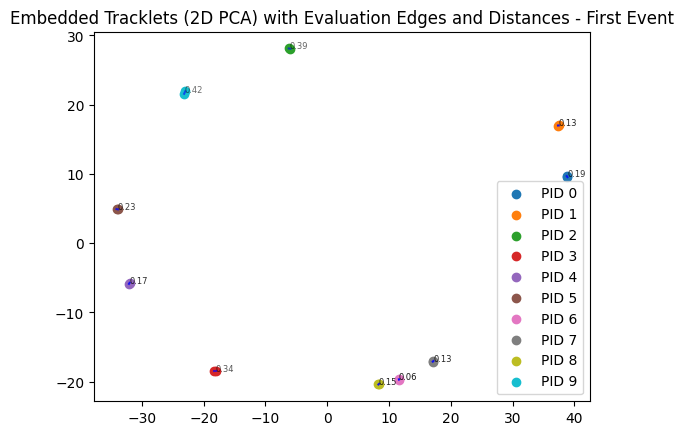

First Batch Metrics:
  Efficiency: 1.0000
  Purity: 0.8495
  Mean True Distance: 0.2301
  Mean Fake Distance: 39.6710


In [6]:
# Now set tracklet pT to be high
model.hparams["dataset_args"]["particle_guns"][0]["pt"] = [10, 11]

# Get dataloader
dataloader = model.train_dataloader()

# Get a batch
batch = next(iter(dataloader))
with torch.no_grad():
    batch = {k: v.to("cuda") if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
    results = model.shared_evaluation(batch, batch_idx=0)

# Get the embeddings
high_pt_embeddings = results["embeddings"].cpu().numpy()

In [9]:
# Select embeddings for the first batch entry
low_pt_embeddings = low_pt_embeddings.reshape(-1, 8)  # Shape: (400*20, 8)
high_pt_embeddings = high_pt_embeddings.reshape(-1, 8)  # Shape: (400*20, 8)

# Create a mask for low and high pT embeddings
num_low_pt = low_pt_embeddings.shape[0]  # 400*20
num_high_pt = high_pt_embeddings.shape[0]  # 400*20

low_pt_mask = np.ones(num_low_pt, dtype=bool)       # [True, True, ..., True] (400*20,)
high_pt_mask = np.zeros(num_high_pt, dtype=bool)    # [False, False, ..., False] (400*20,)
pt_mask = np.concatenate([low_pt_mask, high_pt_mask])  # Shape: (2*400*20,)

# Concatenate low and high pT embeddings for the first batch
all_embeddings = np.concatenate([low_pt_embeddings, high_pt_embeddings], axis=0)  # Shape: (2*400*20, 8)

# Save all embeddings for quick reload, and the mask
np.savez("all_embeddings.npz", all_embeddings, pt_mask)

## Load the embeddings and mask

In [7]:
# Load embeddings, mask and remake arrays
data = np.load("all_embeddings.npz")
all_embeddings = data["arr_0"]
pt_mask = data["arr_1"]

low_pt_embeddings = all_embeddings[pt_mask]
high_pt_embeddings = all_embeddings[~pt_mask]

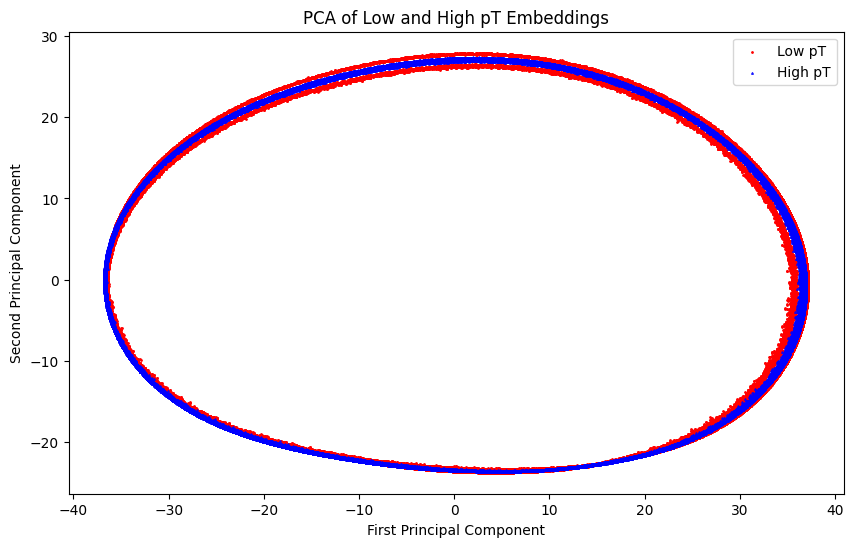

In [8]:
# Plot ALL the embeddings in PCA

from sklearn.decomposition import PCA

# Perform PCA on the concatenated embeddings
pca = PCA(n_components=2)
all_embeddings_pca = pca.fit_transform(all_embeddings)  # Shape: (2*400*20, 2)

# Plot the PCA results
plt.figure(figsize=(10, 6))
plt.scatter(
    all_embeddings_pca[pt_mask, 0],
    all_embeddings_pca[pt_mask, 1],
    c="r",
    marker='o',
    label='Low pT',
    s=1
)
plt.scatter(
    all_embeddings_pca[~pt_mask, 0],
    all_embeddings_pca[~pt_mask, 1],
    c="b",
    marker='^',
    label='High pT',
    s=1
)
plt.legend()
plt.title('PCA of Low and High pT Embeddings')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

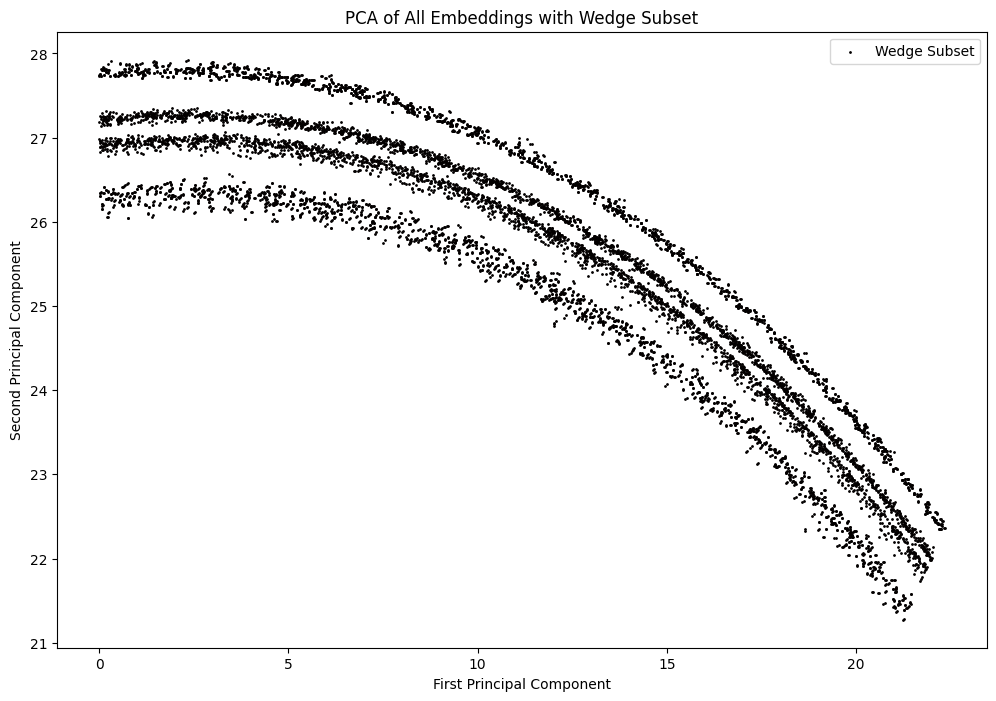

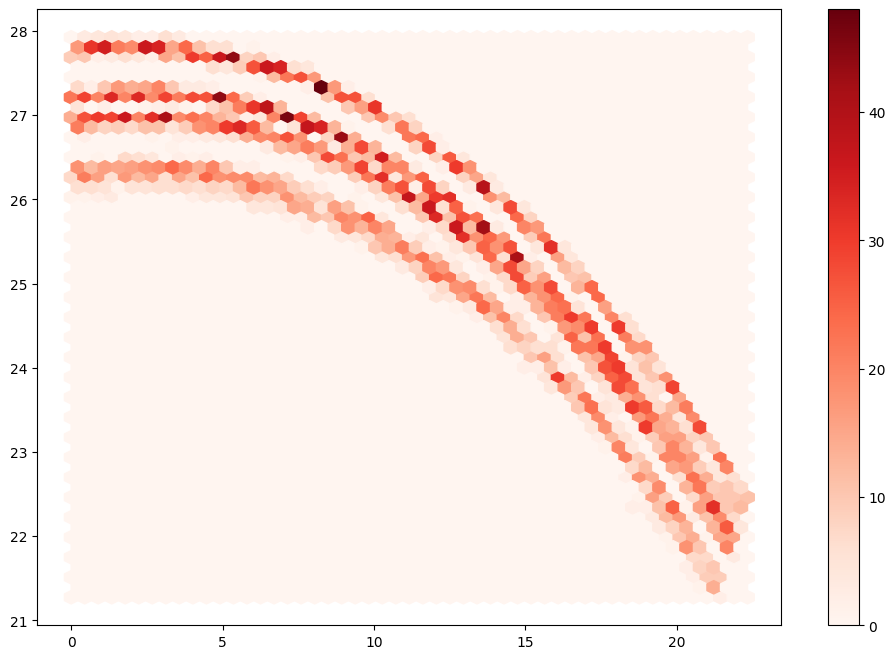

In [42]:
# Select points in the wedge and plot them

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ### Step 1: Prepare the Embeddings

# Reshape embeddings to ensure correct dimensions
low_pt_embeddings = low_pt_embeddings.reshape(-1, 8)   # Shape: (8000, 8)
high_pt_embeddings = high_pt_embeddings.reshape(-1, 8) # Shape: (8000, 8)

# Concatenate low and high pT embeddings
all_embeddings = np.concatenate([low_pt_embeddings, high_pt_embeddings], axis=0)  # Shape: (16000, 8)

# Perform PCA on all embeddings for visualization
pca = PCA(n_components=2)
all_embeddings_pca = pca.fit_transform(all_embeddings)  # Shape: (16000, 2)

# ### Step 2: Create the pT Mask

# Create boolean masks for low and high pT embeddings
num_low_pt = low_pt_embeddings.shape[0]    # 8000
num_high_pt = high_pt_embeddings.shape[0]  # 8000

low_pt_mask = np.ones(num_low_pt, dtype=bool)      # [True, True, ..., True] (8000,)
high_pt_mask = np.zeros(num_high_pt, dtype=bool)   # [False, False, ..., False] (8000,)
pt_mask = np.concatenate([low_pt_mask, high_pt_mask])  # Shape: (16000,)

# ### Step 3: Select a Wedge of Data in PCA Space

# Calculate angles of points in PCA space
angles = np.arctan2(all_embeddings_pca[:, 1], all_embeddings_pca[:, 0])

# Define the wedge range (e.g., between π/4 and π/2)
wedge_min = np.pi / 4
# wedge_min = 0.0
wedge_max = np.pi / 2

# Select points within the wedge
wedge_mask = (angles >= wedge_min) & (angles <= wedge_max)
wedge_indices = np.where(wedge_mask)[0]

# Extract the wedge subset
subset_embeddings = all_embeddings[wedge_indices]        # Shape: (subset_size, 8)
subset_embeddings_pca = all_embeddings_pca[wedge_indices]  # Shape: (subset_size, 2)
subset_pt_mask = pt_mask[wedge_indices]                  # Shape: (subset_size,)

# ### Step 4: Visualize the Wedge Selection

plt.figure(figsize=(12, 8))

# Plot all data points in light gray for context
# plt.scatter(
#     all_embeddings_pca[:, 0],
#     all_embeddings_pca[:, 1],
#     c="lightgray",
#     marker='o',
#     s=1,
#     alpha=0.3,
#     label='All Data'
# )

# Overlay the wedge subset
plt.scatter(
    subset_embeddings_pca[:, 0],
    subset_embeddings_pca[:, 1],
    c="red",
    marker='o',
    s=1,
    edgecolor='k',
    label='Wedge Subset'
)

# Add a legend
plt.legend()

# Set plot titles and labels
plt.title('PCA of All Embeddings with Wedge Subset')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Display the plot
plt.show()

# Make a 2d histogram of the subset embeddings, with hex

plt.figure(figsize=(12, 8))
plt.hexbin(
    x=subset_embeddings_pca[:, 0],
    y=subset_embeddings_pca[:, 1],
    gridsize=50,
    cmap='Reds'
)
plt.colorbar()
plt.show()



## Graph Community Detection

In [39]:
# Import necessary libraries
from sklearn.neighbors import kneighbors_graph
import networkx as nx
from community import community_louvain

# Step 1: Create KNN Graph
n_neighbors = 20  # You can adjust this value
knn_graph = kneighbors_graph(subset_embeddings_pca, n_neighbors, mode='distance', include_self=False)

# Convert to NetworkX graph
G = nx.from_scipy_sparse_array(knn_graph)

In [ ]:
# knn_graph is CSR, convert to COO
knn_graph = knn_graph.tocoo()

# Now we have a 2xN list of edges
edges = np.array([knn_graph.row, knn_graph.col])

# Visualize the KNN graph, using plot of edges, with VERY high definition
plt.figure(figsize=(12, 8), dpi=600)

plt.scatter(subset_embeddings_pca[:, 0], subset_embeddings_pca[:, 1], c='k', s=1)
plt.plot(subset_embeddings_pca[edges, 0], subset_embeddings_pca[edges, 1], linewidth=0.1, alpha=0.8, color="b");

plt.title('KNN Graph')
plt.show()

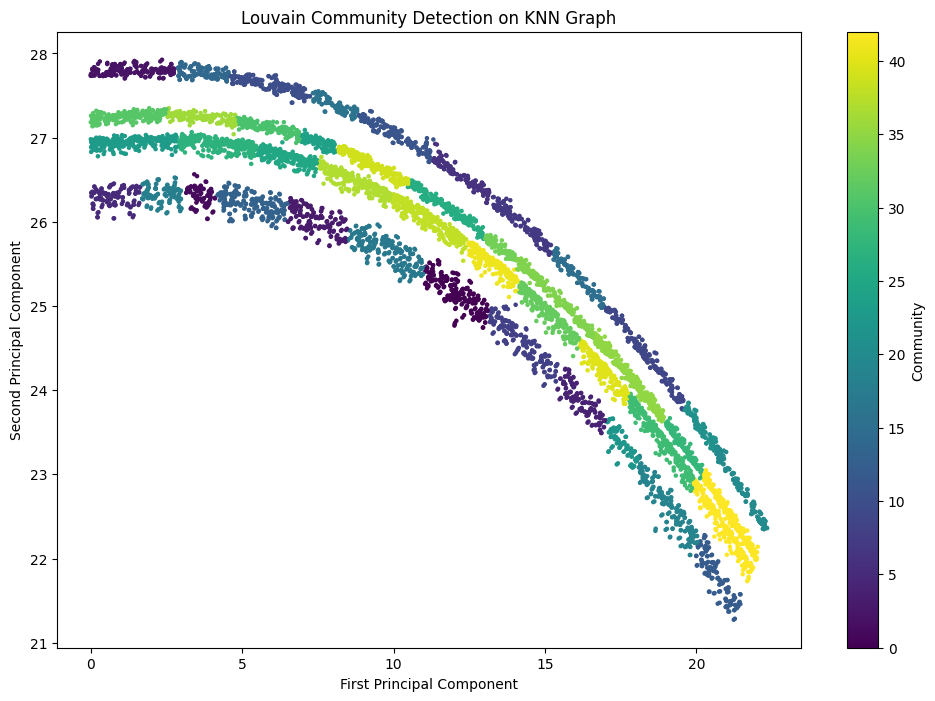

Number of communities detected: 43


In [8]:
# Step 3: Visualize the results
plt.figure(figsize=(12, 8))
colors = [partition[i] for i in range(len(subset_embeddings_pca))]
plt.scatter(subset_embeddings_pca[:, 0], subset_embeddings_pca[:, 1], c=colors, cmap='viridis', s=5)
plt.colorbar(label='Community')
plt.title('Louvain Community Detection on KNN Graph')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

# Print the number of communities detected
num_communities = len(set(partition.values()))
print(f"Number of communities detected: {num_communities}")

Number of communities: 5


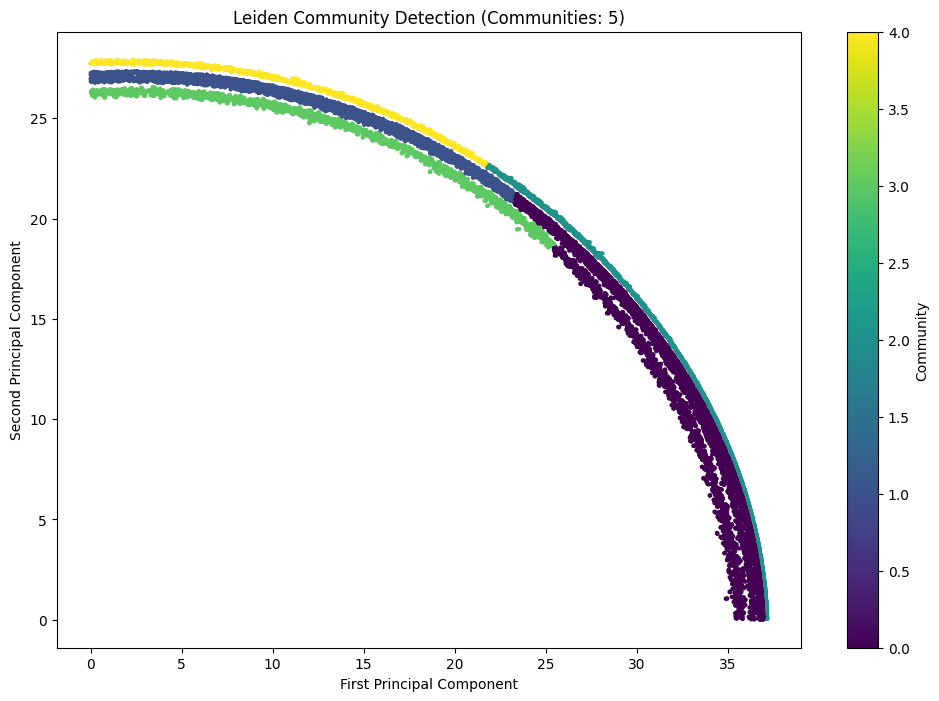

In [41]:
import leidenalg
import igraph as ig

# Convert NetworkX graph to iGraph
igraph_graph = ig.Graph.from_networkx(G)

# Function to apply Leiden with a given resolution
def apply_leiden(igraph_graph):
    partition = leidenalg.find_partition(
        igraph_graph, 
        leidenalg.RBConfigurationVertexPartition,
        resolution_parameter=0.003
    )
    partition_dict = {node: comm for node, comm in enumerate(partition.membership)}
    num_communities = len(set(partition_dict.values()))
    return partition_dict, num_communities

partition, num_comm = apply_leiden(igraph_graph)
print(f"Number of communities: {num_comm}")

# Visualize the results
plt.figure(figsize=(12, 8))
colors = [partition[i] for i in range(len(subset_embeddings_pca))]
plt.scatter(subset_embeddings_pca[:, 0], subset_embeddings_pca[:, 1], c=colors, cmap='viridis', s=5)
plt.colorbar(label='Community')
plt.title(f'Leiden Community Detection (Communities: {num_comm})')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

In [21]:
set(partition.values())

SyntaxError: '(' was never closed (963923168.py, line 1)